In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [3]:
print(tf.__version__)

2.7.0


# GETTING OUR DATA

In [160]:
dftrain = pd.read_csv("train.csv")
dftest = pd.read_csv("test.csv")

In [5]:
dftrain.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
dftrain = dftrain.sample(frac=1,random_state=42)
dftrain.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


# BECOMING ONE WITH THE DATA

In [7]:
print(f'LENGTH OF THE TRAINING DATASET: {len(dftrain)}')
print(f'LENGTH OF THE TEST DATASET: {len(dftest)}')

LENGTH OF THE TRAINING DATASET: 7613
LENGTH OF THE TEST DATASET: 3263


In [8]:
dftrain["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
import random
rand_index = random.randint(0,len(dftrain)-1)
for row in dftrain[["text","target"]][rand_index:rand_index+10].itertuples():
    _,text,target = row #_ is for index(it basically means that we dont want to store the returned index in any variable)
    print(f'THE TEXT IS: {text}')
    print(f'THE LABEL FOR THE ABOVE TEXT IS: {target}',("REAL DISASTER") if target==1 else ("NOT A DISASTER"))
    print('\n\n\n -----')
    

THE TEXT IS: Thinking about getting a demo car with a friend and joining the demolition derby in kenosha
THE LABEL FOR THE ABOVE TEXT IS: 0 NOT A DISASTER



 -----
THE TEXT IS: Police Officer Wounded Suspect Dead After Exchanging Shots: Richmond police officer wounded suspect killed a... http://t.co/w0r8EAOKA0
THE LABEL FOR THE ABOVE TEXT IS: 1 REAL DISASTER



 -----
THE TEXT IS: Don't be the cause of your own self destruction
THE LABEL FOR THE ABOVE TEXT IS: 0 NOT A DISASTER



 -----
THE TEXT IS: #hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/UMgD92wLjA #prebreak #best
THE LABEL FOR THE ABOVE TEXT IS: 1 REAL DISASTER



 -----
THE TEXT IS: Cross-border terrorism: Pakistan caught red-handed again - The Times of India http://t.co/uiqsfgZoOx
THE LABEL FOR THE ABOVE TEXT IS: 1 REAL DISASTER



 -----
THE TEXT IS: #News : The Latest: More Homes Razed by Northern California Wildfire - New York Times http://t.co/5kBRZZmf8c #TAFS #FB100%
THE LA

# SPLITTING INTO TRAIN AND VALIDATION DATASETS

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_sentences,valid_sentences,train_labels,valid_labels = train_test_split(dftrain["text"].to_numpy(),
                                                                             dftrain["target"].to_numpy(),
                                                                             test_size=0.2,
                                                                             random_state=42)

In [12]:
len(train_sentences),len(valid_sentences)

(6090, 1523)

# CREATING [TEXT VECTORIZATION LAYER](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

In [13]:
# average length of tweets in the dataset
avg_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
avg_length

15

In [14]:
# total number of words in our dataset
round(sum([len(i.split()) for i in train_sentences]))

90705

In [15]:
max_words = 10000 # total words in our vocabulary
max_length = 15 # length of the tweet to consider

In [16]:
from tensorflow.keras.layers import TextVectorization

In [17]:
text_vect_layer = TextVectorization(max_tokens = max_words,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [18]:
text_vect_layer.adapt(train_sentences)

In [19]:
# exploring the output of our text vectorization layer
r = random.randint(0,len(train_sentences)-1)
print(f'ORIGINAL SENTENCE: \n{train_sentences[r]}')
print(f'TEXT VECTORIZED OUTPUT: \n{text_vect_layer(train_sentences[r])}')

ORIGINAL SENTENCE: 
This is the natural and unavoidable consequence of socialism everywhere it has been tried.
http://t.co/BbDpnj8XSx F
TEXT VECTORIZED OUTPUT: 
[  19    9    2  271    7 3027 3671    6 3127 1411   15   39   61 1009
 3491]


# EXPLORING OUR VOCABULARY

In [20]:
words_in_vocab = text_vect_layer.get_vocabulary()
most_common = words_in_vocab[:9]
least_common = words_in_vocab[-9:]
len(words_in_vocab)

10000

In [21]:
most_common #['UNK'] means unknown, since our layer has OOV token(out of vocabulary)eg: #,! or some other symbols

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i']

In [22]:
least_common

['mineness',
 'mineenjoyfire',
 'mindset',
 'mindless',
 'minded',
 'mindblowing',
 'milne',
 'milledgeville',
 'millcityio']

# CREATING [EMBEDDING LAYER](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
* input_dim: size of the vocabulary
* input_length: length of the sequences
* output_dim: size of the output matrix (usually a multiple of 8 eg. 8,16,128,etc.)

In [23]:
embedding_layer = tf.keras.layers.Embedding(input_dim = max_words,
                                            input_length = max_length,
                                            output_dim = 128)
embedding_layer

In [24]:
#exploring the outputs of the embedding layer
r = random.randint(0,len(train_sentences)-1)
output = embedding_layer(text_vect_layer(train_sentences[r]))
output

<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
array([[ 0.03444836,  0.04864522, -0.00724417, ...,  0.00154948,
        -0.02113111,  0.00023873],
       [-0.01101712,  0.02519188,  0.00549589, ...,  0.00552434,
         0.03475556,  0.02523443],
       [ 0.04161661,  0.00812791,  0.02180555, ...,  0.00765867,
        -0.03451526, -0.00084474],
       ...,
       [-0.02913681,  0.00521258, -0.00063428, ..., -0.00573288,
        -0.02505815, -0.04516473],
       [ 0.03956198, -0.04485343,  0.03776437, ..., -0.04057055,
        -0.01021559,  0.04447547],
       [ 0.04167077, -0.03317765, -0.01853063, ...,  0.00145965,
        -0.04080532, -0.03019362]], dtype=float32)>

In [25]:
output[0] #embedding for one word

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 3.44483592e-02,  4.86452244e-02, -7.24416971e-03,  4.49999012e-02,
       -1.96938645e-02, -3.04350387e-02,  2.40769275e-02, -1.57578476e-02,
        1.22558847e-02,  1.10806599e-02,  7.45065138e-03,  1.38899945e-02,
        1.14321336e-02, -2.71680206e-03, -2.20036395e-02,  1.88633092e-02,
       -1.09168664e-02,  6.42314553e-05,  1.88246705e-02, -3.37535739e-02,
       -2.17928644e-02, -3.10135242e-02,  3.40928920e-02,  5.56747988e-03,
       -8.73624161e-03, -3.78175825e-03,  1.82912014e-02,  3.56566347e-02,
       -3.43958624e-02,  4.65800501e-02, -3.84412706e-04,  3.58618237e-02,
       -1.14396326e-02, -1.41988285e-02,  3.15286964e-03,  1.47016309e-02,
       -1.84397325e-02, -2.39029061e-02, -2.47873664e-02, -3.38607915e-02,
        1.97753944e-02, -4.00042906e-02, -3.11858580e-03,  1.60645284e-02,
       -2.93135401e-02,  5.37934154e-03,  2.01000236e-02,  2.82634757e-02,
       -1.98282301e-04, -1.14201903e-02,  3.79750244

# TESTING THE FOLLOWING MODELS FOR NLP: 
* #### MODEL1 : SKLEARN TF-IDF ENCODER
* #### MODEL2 : FEED FORWARD NEURAL NETWORK (DENSE)
* #### MODEL3 : LSTM
* #### MODEL4 : GRU
* #### MODEL5 : BIDIRECTIONAL LSTM
* #### MODEL6 : 1-D CONVOLUTIONAL LAYER
* #### MODEL7 : PRETAINED FEATURE EXTRACTOR MODEL FROM TENSORFLOW HUB
* #### MODEL8 : PRETAINED FEATURE EXTRACTOR MODEL FROM TENSORFLOW HUB AND TRAINED ONLY ON 10% OF DATA

# MODEL1 : SKLEARN TF-IDF ENCODER

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
model1 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [28]:
model1.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
model1.score(valid_sentences,valid_labels)

0.799080761654629

In [30]:
def show_classification_report(y_true,y_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    acc = accuracy_score(y_pred,y_true)
    precision, recall, fscore,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "fscore": fscore
    }
    return metrics

In [31]:
model1_report = show_classification_report(valid_labels,model1.predict(valid_sentences))
model1_report

{'accuracy': 0.799080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'fscore': 0.7920155324845473}

# MODEL2 : FEED FORWARD NEURAL NETWORK (DENSE)

In [32]:
inputs = tf.keras.Input(shape = (1,),dtype="string")
x = text_vect_layer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x) #globalaveragepooling layer to condense the output
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model2 = tf.keras.models.Model(inputs,outputs)

In [33]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [34]:
model2.compile(loss = "binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = "accuracy")

In [35]:
from helperfuncs import tensor_board_callback
history2 = model2.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model2")])

Epoch 1/5
191/191 [==============================] - 3s 7ms/step - loss: 0.6491 - accuracy: 0.6361 - val_loss: 0.5886 - val_accuracy: 0.7656
Epoch 2/5
191/191 [==============================] - 1s 5ms/step - loss: 0.4893 - accuracy: 0.8268 - val_loss: 0.4828 - val_accuracy: 0.7846
Epoch 3/5
191/191 [==============================] - 1s 5ms/step - loss: 0.3527 - accuracy: 0.8742 - val_loss: 0.4569 - val_accuracy: 0.7912
Epoch 4/5
191/191 [==============================] - 1s 5ms/step - loss: 0.2641 - accuracy: 0.9071 - val_loss: 0.4592 - val_accuracy: 0.7945
Epoch 5/5
191/191 [==============================] - 1s 5ms/step - loss: 0.2011 - accuracy: 0.9350 - val_loss: 0.4723 - val_accuracy: 0.7997


In [36]:
pred = model2.predict(valid_sentences)
pred,pred.shape

(array([[0.41941515],
        [0.9123423 ],
        [0.99131423],
        ...,
        [0.21779887],
        [0.961898  ],
        [0.998139  ]], dtype=float32),
 (1523, 1))

In [37]:
pred = tf.round(tf.squeeze(pred))
pred,pred.shape

(<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 1., 1.], dtype=float32)>,
 TensorShape([1523]))

In [38]:
model2_report = show_classification_report(pred,valid_labels)
model2_report

{'accuracy': 0.7997373604727511,
 'precision': 0.8142940551172227,
 'recall': 0.7997373604727511,
 'fscore': 0.8027716306279735}

In [39]:
model1_report,model2_report

({'accuracy': 0.799080761654629,
  'precision': 0.8146358812834972,
  'recall': 0.799080761654629,
  'fscore': 0.7920155324845473},
 {'accuracy': 0.7997373604727511,
  'precision': 0.8142940551172227,
  'recall': 0.7997373604727511,
  'fscore': 0.8027716306279735})

### VISIUALIZING WORD EMBEDDING USING [TENSORFLOW EMBEDDING PROJECTOR](http://projector.tensorflow.org/)

In [40]:
for layer in model2.layers:
    print(layer.name)

input_1
text_vectorization
embedding
global_max_pooling1d
dense


In [41]:
#CODE TO DOWNLOAD THE WORD VECTORS AND METADATA
# import io
# weights = model2.get_layer("embedding").get_weights()[0]
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

# MODEL3 : [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In [42]:
inputs = tf.keras.Input(shape=(1,),dtype="string")
x = text_vect_layer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.LSTM(64,return_sequences=True)(x) #default parameters of this layer are pretty good
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model3 = tf.keras.models.Model(inputs,outputs)
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65  

In [43]:
model3.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [44]:
history3 = model3.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model3")])

Epoch 1/5
191/191 [==============================] - 5s 10ms/step - loss: 0.4027 - accuracy: 0.8154 - val_loss: 0.4711 - val_accuracy: 0.7925
Epoch 2/5
191/191 [==============================] - 1s 8ms/step - loss: 0.2480 - accuracy: 0.9016 - val_loss: 0.5117 - val_accuracy: 0.7866
Epoch 3/5
191/191 [==============================] - 2s 8ms/step - loss: 0.1753 - accuracy: 0.9366 - val_loss: 0.6288 - val_accuracy: 0.7748
Epoch 4/5
191/191 [==============================] - 1s 8ms/step - loss: 0.1261 - accuracy: 0.9555 - val_loss: 0.8410 - val_accuracy: 0.7564
Epoch 5/5
191/191 [==============================] - 1s 8ms/step - loss: 0.1060 - accuracy: 0.9612 - val_loss: 0.7765 - val_accuracy: 0.7807


In [45]:
y_pred = model3.predict(valid_sentences)

In [46]:
y_pred = tf.round(tf.squeeze(y_pred))
y_pred

<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [47]:
model3_report = show_classification_report(valid_labels,y_pred)
model3_report

{'accuracy': 0.7806959947472094,
 'precision': 0.7828413926132761,
 'recall': 0.7806959947472094,
 'fscore': 0.7773313366017781}

# MODEL4 : [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) 

In [48]:
inputs = tf.keras.Input(shape=(1,),dtype="string")
x = text_vect_layer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.GRU(64,return_sequences=True)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model4 = tf.keras.models.Model(inputs,outputs)
model4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 65  

In [49]:
model4.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [50]:
history4 = model4.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model4")])

Epoch 1/5
191/191 [==============================] - 3s 10ms/step - loss: 0.1920 - accuracy: 0.9297 - val_loss: 0.7533 - val_accuracy: 0.7630
Epoch 2/5
191/191 [==============================] - 1s 7ms/step - loss: 0.0953 - accuracy: 0.9675 - val_loss: 0.7952 - val_accuracy: 0.7676
Epoch 3/5
191/191 [==============================] - 1s 7ms/step - loss: 0.0837 - accuracy: 0.9693 - val_loss: 0.8393 - val_accuracy: 0.7702
Epoch 4/5
191/191 [==============================] - 1s 7ms/step - loss: 0.0675 - accuracy: 0.9741 - val_loss: 1.0445 - val_accuracy: 0.7511
Epoch 5/5
191/191 [==============================] - 1s 7ms/step - loss: 0.0597 - accuracy: 0.9764 - val_loss: 1.2128 - val_accuracy: 0.7472


In [51]:
y_pred = model4.predict(valid_sentences)
y_pred = tf.round(tf.squeeze(y_pred))
y_pred

<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [52]:
model4_report = show_classification_report(valid_labels,y_pred)
model4_report

{'accuracy': 0.747209455022981,
 'precision': 0.746289244406328,
 'recall': 0.747209455022981,
 'fscore': 0.7464359404819112}

# MODEL5 : BIDERECTIONAL LSTM

In [53]:
inputs = tf.keras.Input(shape=(1,),dtype="string")
x = text_vect_layer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model5 = tf.keras.models.Model(inputs,outputs)
model5.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,625
Non-tra

In [54]:
model5.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [55]:
history5 = model5.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model5")])

Epoch 1/5
191/191 [==============================] - 4s 12ms/step - loss: 0.1509 - accuracy: 0.9458 - val_loss: 0.8857 - val_accuracy: 0.7682
Epoch 2/5
191/191 [==============================] - 1s 8ms/step - loss: 0.0673 - accuracy: 0.9750 - val_loss: 0.8457 - val_accuracy: 0.7597
Epoch 3/5
191/191 [==============================] - 1s 8ms/step - loss: 0.0549 - accuracy: 0.9783 - val_loss: 1.0699 - val_accuracy: 0.7682
Epoch 4/5
191/191 [==============================] - 2s 8ms/step - loss: 0.0492 - accuracy: 0.9791 - val_loss: 1.0823 - val_accuracy: 0.7544
Epoch 5/5
191/191 [==============================] - 2s 8ms/step - loss: 0.0412 - accuracy: 0.9814 - val_loss: 1.3264 - val_accuracy: 0.7695


In [56]:
y_pred = model5.predict(valid_sentences)
y_pred = tf.round(tf.squeeze(y_pred))
y_pred

<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [57]:
model5_report = show_classification_report(valid_labels,y_pred)
model5_report

{'accuracy': 0.7695338148391333,
 'precision': 0.7724074633725272,
 'recall': 0.7695338148391333,
 'fscore': 0.7653093670217364}

# MODEL6 : CONV1D MODEL

In [58]:
inputs = tf.keras.Input(shape=(1,),dtype="string")
x = text_vect_layer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.Conv1D(filters = 32,
                           kernel_size = 4,
                           padding = "same")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model6 = tf.keras.models.Model(inputs,outputs)
model6.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 32)            16416     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 33  

In [59]:
model6.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [60]:
from helperfuncs import tensor_board_callback
history6 = model6.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model6")])

Epoch 1/5
191/191 [==============================] - 4s 7ms/step - loss: 0.1812 - accuracy: 0.9448 - val_loss: 0.7271 - val_accuracy: 0.7610
Epoch 2/5
191/191 [==============================] - 1s 6ms/step - loss: 0.0730 - accuracy: 0.9741 - val_loss: 0.8889 - val_accuracy: 0.7544
Epoch 3/5
191/191 [==============================] - 1s 6ms/step - loss: 0.0554 - accuracy: 0.9783 - val_loss: 0.9775 - val_accuracy: 0.7695
Epoch 4/5
191/191 [==============================] - 1s 6ms/step - loss: 0.0470 - accuracy: 0.9818 - val_loss: 1.0528 - val_accuracy: 0.7610
Epoch 5/5
191/191 [==============================] - 1s 6ms/step - loss: 0.0465 - accuracy: 0.9819 - val_loss: 1.0466 - val_accuracy: 0.7544


In [61]:
y_pred = model6.predict(valid_sentences)
y_pred = tf.round(tf.squeeze(y_pred))
y_pred

<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [62]:
model6_report = show_classification_report(valid_labels,y_pred)
model6_report

{'accuracy': 0.7544320420223244,
 'precision': 0.7539959830174011,
 'recall': 0.7544320420223244,
 'fscore': 0.7541667967465202}

# MODEL7 :  PRETAINED FEATURE EXTRACTOR MODEL FROM TENSORFLOW HUB ([PRETAINED WORD EMBEDDING](https://tfhub.dev/google/universal-sentence-encoder/4))

In [63]:
import tensorflow_hub as hub
embed = hub.load("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp\\universal-sentence-encoder_4.tar")

In [64]:
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

In [65]:
print(embeddings[0][:50])

tf.Tensor(
[-0.03133019 -0.06338634 -0.01607501 -0.01034895 -0.04650102  0.03723156
  0.00591583  0.07174398  0.01666447  0.06090763  0.06655259  0.02370512
  0.00057647  0.05684322  0.02416169 -0.00533627  0.04704772  0.01921571
  0.07682553  0.00566961 -0.07528221 -0.01713724 -0.07502711  0.07637348
 -0.05437959 -0.00138911 -0.01830184 -0.0467204  -0.04724139  0.02706783
  0.03233341  0.0553706   0.03370956 -0.01370662  0.00552706 -0.08226925
  0.01419506  0.06827912  0.01832053 -0.02147872  0.04149668 -0.02027399
 -0.00601058  0.02448247 -0.0884009  -0.02566542 -0.03832615 -0.05610626
  0.04681282  0.03203126], shape=(50,), dtype=float32)


In [66]:
print(embeddings.shape)

(2, 512)


In [67]:
embed = hub.KerasLayer("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp\\universal-sentence-encoder_4.tar",
                      input_shape=[],
                       dtype = tf.string,
                      trainable = False)

In [68]:
model7 = tf.keras.Sequential([
    embed,
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [69]:
model7.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [70]:
from helperfuncs import tensor_board_callback
history7 = model7.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model7")])

Epoch 1/5
191/191 [==============================] - 5s 17ms/step - loss: 0.5083 - accuracy: 0.7908 - val_loss: 0.4524 - val_accuracy: 0.7925
Epoch 2/5
191/191 [==============================] - 3s 15ms/step - loss: 0.4131 - accuracy: 0.8136 - val_loss: 0.4441 - val_accuracy: 0.7938
Epoch 3/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3983 - accuracy: 0.8212 - val_loss: 0.4414 - val_accuracy: 0.8017
Epoch 4/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3902 - accuracy: 0.8286 - val_loss: 0.4395 - val_accuracy: 0.8050
Epoch 5/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3838 - accuracy: 0.8291 - val_loss: 0.4378 - val_accuracy: 0.8089


In [71]:
y_pred = model7.predict(valid_sentences)
y_pred = tf.round(tf.squeeze(y_pred))
model7_report = show_classification_report(valid_labels,y_pred)
model7_report

{'accuracy': 0.8089297439264609,
 'precision': 0.8084424462780744,
 'recall': 0.8089297439264609,
 'fscore': 0.8083879035926637}

# MODEL8 : PRETAINED FEATURE EXTRACTOR MODEL FROM TENSORFLOW HUB AND TRAINED ONLY ON 10% OF DATA

In [72]:
# PREPARING THE 10% DATASET
len(train_sentences)
train = train_sentences[:740]
labels = train_labels[:740]

In [73]:
train10,valid10,label10,vlabel10 = train_test_split(train,labels,test_size = 0.2)

In [74]:
len(train10),len(valid10)

(592, 148)

In [75]:
model8 = tf.keras.Sequential([
    embed,
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [76]:
model8.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [80]:
from helperfuncs import tensor_board_callback
history8 = model8.fit(train,labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model8")])

Epoch 1/5
24/24 [==============================] - 1s 48ms/step - loss: 0.2933 - accuracy: 0.8932 - val_loss: 0.4614 - val_accuracy: 0.7958
Epoch 2/5
24/24 [==============================] - 1s 36ms/step - loss: 0.2804 - accuracy: 0.9014 - val_loss: 0.4676 - val_accuracy: 0.7938
Epoch 3/5
24/24 [==============================] - 1s 35ms/step - loss: 0.2684 - accuracy: 0.9027 - val_loss: 0.4722 - val_accuracy: 0.7905
Epoch 4/5
24/24 [==============================] - 1s 37ms/step - loss: 0.2570 - accuracy: 0.9095 - val_loss: 0.4808 - val_accuracy: 0.7905
Epoch 5/5
24/24 [==============================] - 1s 36ms/step - loss: 0.2467 - accuracy: 0.9122 - val_loss: 0.4869 - val_accuracy: 0.7899


In [82]:
y_pred = model8.predict(valid_sentences)
y_pred = tf.round(tf.squeeze(y_pred))
y_pred

<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 0., 1.], dtype=float32)>

In [83]:
model8_report = show_classification_report(valid_labels,y_pred)
model8_report

{'accuracy': 0.7898883782009193,
 'precision': 0.7896358950547268,
 'recall': 0.7898883782009193,
 'fscore': 0.7897401375194602}

# VISUALIZING THE PERFORMANCE OF ALL OUR MODELS

In [93]:
import pandas as pd
model_reports = pd.DataFrame({"BASELINE1": model1_report,
                              "FEEDFORWARDNET2": model2_report,
                              "LSTM3":model3_report,
                              "GRU4":model4_report,
                              "BIDIRECTIONAL5":model5_report,
                              "CONV1D6":model6_report,
                              "PRETRAINEDUSE": model7_report,
                              "10%PRETRAINEDUSE":model8_report})
model_reports = model_reports.transpose()
model_reports

,accuracy,precision,recall,fscore
BASELINE1,0.799081,0.814636,0.799081,0.792016
FEEDFORWARDNET2,0.799737,0.814294,0.799737,0.802772
LSTM3,0.780696,0.782841,0.780696,0.777331
GRU4,0.747209,0.746289,0.747209,0.746436
BIDIRECTIONAL5,0.769534,0.772407,0.769534,0.765309
CONV1D6,0.754432,0.753996,0.754432,0.754167
PRETRAINEDUSE,0.808930,0.808442,0.808930,0.808388
10%PRETRAINEDUSE,0.789888,0.789636,0.789888,0.789740


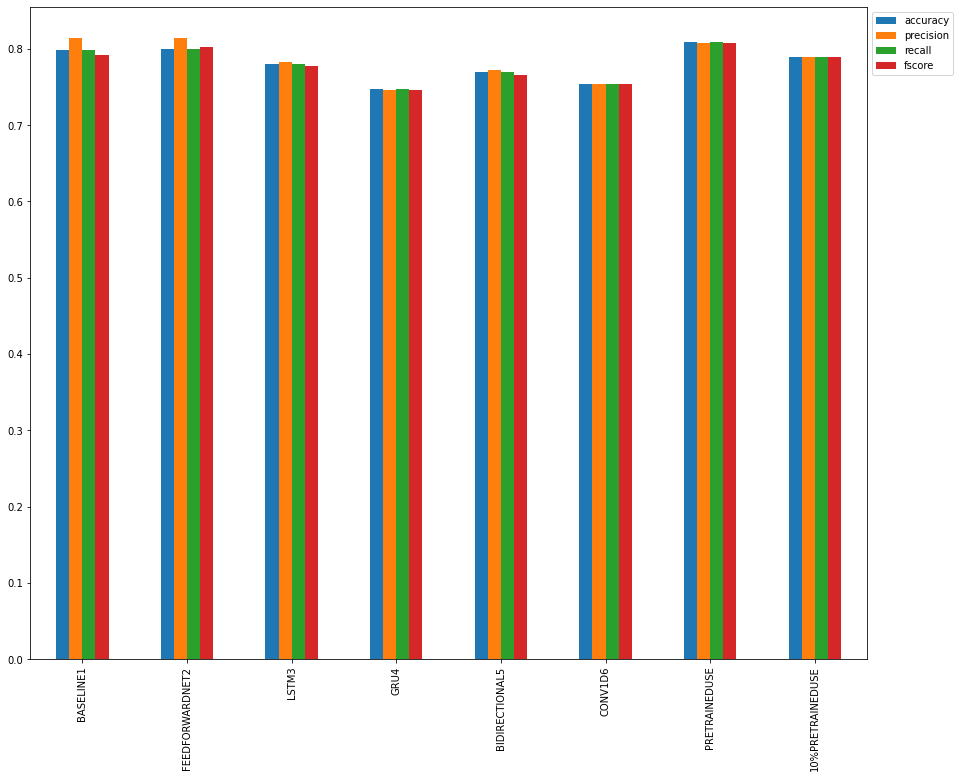

In [96]:
model_reports.plot(kind="bar",figsize=(15,12)).legend(bbox_to_anchor=(1.0,1.0))

<AxesSubplot:>

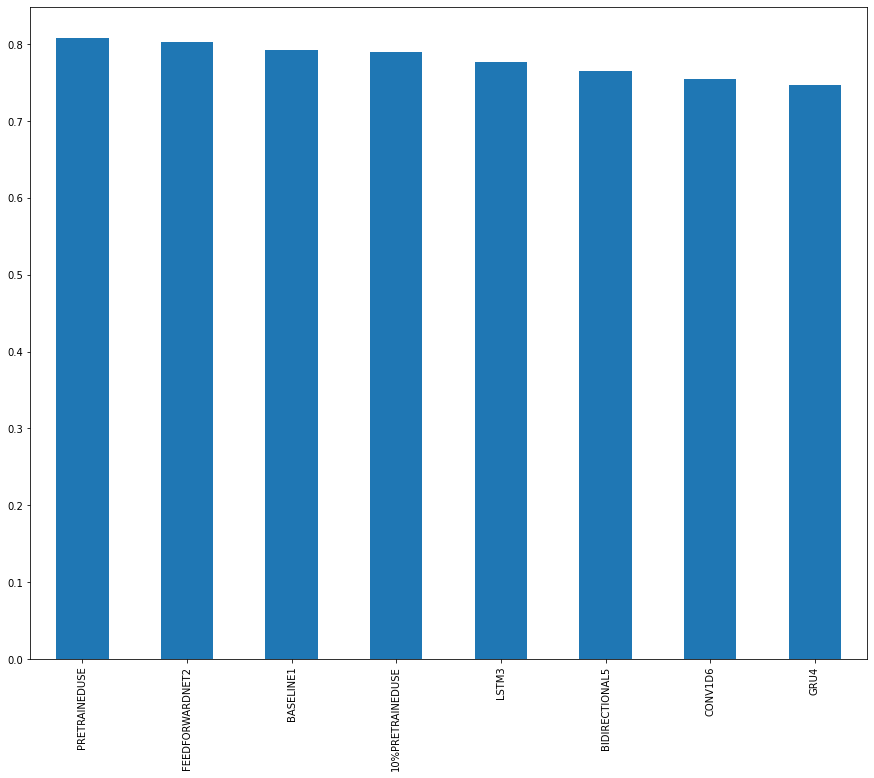

In [101]:
model_reports["fscore"].sort_values(ascending=False).plot(kind="bar",figsize=(15,12))

# VISUALIZING THE PERFORMANCE OF THE MODELS USING TENSORBOARD

In [105]:
! tensorboard dev upload --logdir ./model_logs/ \
 --name "NLP MODELS" \
 --description "COMPARING THE PERFORMANCES OF 8 MODELS ON KAGGLE TWEET CLASSIFICATION DATASET" \
 --one_shot

^C


[LINK FOR THE EXPERIMENTS](https://tensorboard.dev/experiment/khYJ69rxQA25MvWHLNnVqQ/)

In [106]:
! tensorboard dev list

https://tensorboard.dev/experiment/khYJ69rxQA25MvWHLNnVqQ/
	Name                 NLP MODELS
	Description          COMPARING THE PERFORMANCE OF 8 MODELS ON THE KAGGLE TWEETS DATASET
	Id                   khYJ69rxQA25MvWHLNnVqQ
	Created              2021-11-24 15:45:06 (6 minutes ago)
	Updated              2021-11-24 15:45:23 (6 minutes ago)
	Runs                 14
	Tags                 5
	Scalars              210
	Tensor bytes         0
	Binary object bytes  2895042
https://tensorboard.dev/experiment/QN9c5BvVQ6G36E9uYvy3Mw/
	Name                 comparing the performance of 4 models
	Description          fine tuning, without fine tuning and both with data augumentation
	Id                   QN9c5BvVQ6G36E9uYvy3Mw
	Created              2021-11-03 17:31:31
	Updated              2021-11-03 17:31:35
	Runs                 8
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  3386563
https://tensorboard.dev/experiment/oD2aJ139SpmOtocwyTokNg/
	Name 

Total: 3 experiment(s)


# SAVING THE BEST PERFORMING MODEL

In [108]:
#model7 is the best model
model7.save("best_model_outof8")

INFO:tensorflow:Assets written to: best_model_outof8\assets


# VISUALIZING THE WRONG DECISIONS WITH HIGHEST PROBABILITIES OF THE BEST MODEL

In [162]:
pred_probs = model7.predict(valid_sentences)
pred = tf.round(tf.squeeze(pred_probs))
pred

<tf.Tensor: shape=(1523,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 1., 1.], dtype=float32)>

In [163]:
wrong_probs = pred_probs[pred!=valid_labels]
wrong_sentences = valid_sentences[pred!=valid_labels]
target = valid_labels[pred!=valid_labels]
wrong_pred = pred[pred!=valid_labels]

In [164]:
len(wrong_probs),len(wrong_sentences),wrong_sentences.ndim,wrong_probs.ndim,wrong_probs.shape

(291, 291, 1, 2, (291, 1))

In [165]:
wrong_probs = tf.squeeze(wrong_probs).numpy()
wrong_probs.shape

(291,)

In [166]:
dict = {'wrong_sentences':wrong_sentences,
        'probs' : wrong_probs,
        'target':target,
        'pred' : wrong_pred}
wrong_df = pd.DataFrame(dict)
wrong_df.head()

,wrong_sentences,probs,target,pred
0,FedEx no longer to transport bioterror germs i...,0.860922,0,1.0
1,@camilacabello97 Internally and externally scr...,0.147763,1,0.0
2,@RedCoatJackpot *As it was typical for them th...,0.687946,0,1.0
3,k_matako_bot: Breaking news! Unconfirmed! I ju...,0.629336,0,1.0
4,there's this person &amp; they reckon when you...,0.529321,0,1.0


In [167]:
wrong_df.sort_values("probs",ascending=False,inplace=True)
wrong_df.head()

,wrong_sentences,probs,target,pred
164,@adorableappple No reported flooding po in the...,0.973612,0,1.0
247,We should all have a fire safety plan. RT @Mat...,0.951333,0,1.0
157,Mourning notices for stabbing arson victims st...,0.947428,0,1.0
284,Two Jewish Terrorists Charged In Historic-Chur...,0.938744,0,1.0
137,FedEx will no longer transport bioterror patho...,0.933159,0,1.0


In [168]:
wrong_df.tail()

,wrong_sentences,probs,target,pred
179,'I did another one I did another one. You stil...,0.042020,1,0.0
9,Why are you deluged with low self-image? Take ...,0.035838,1,0.0
139,destroy the free fandom honestly,0.034921,1,0.0
45,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,0.032780,1,0.0
7,Ron &amp; Fez - Dave's High School Crush https...,0.028860,1,0.0


In [169]:
for row in wrong_df.head(20).itertuples():
    _,sentence,probs,target,pred = row
    print(f'SENTENCE: {sentence}\n TARGET: {target} PREDICTION: {pred} PROBABILITY: {probs}')
    print('-------')

SENTENCE: @adorableappple No reported flooding po in the area. Ten-4. #mmda
 TARGET: 0 PREDICTION: 1.0 PROBABILITY: 0.9736121296882629
-------
SENTENCE: We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv
 TARGET: 0 PREDICTION: 1.0 PROBABILITY: 0.951333224773407
-------
SENTENCE: Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe
 TARGET: 0 PREDICTION: 1.0 PROBABILITY: 0.9474281072616577
-------
SENTENCE: Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW
 TARGET: 0 PREDICTION: 1.0 PROBABILITY: 0.938744306564331
-------
SENTENCE: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
 TARGET: 0 PREDICTION: 1.0 PROBABILITY: 0.9331591725349426
-------
SENTENCE: ? High Skies - Burning Buildings ? ht

In [170]:
for row in wrong_df.tail(20).itertuples():
    _,sentence,probs,target,pred = row
    print(f'SENTENCE: {sentence}\n TARGET: {target} PREDICTION: {pred} PROBABILITY: {probs}')
    print('-------')

SENTENCE: But if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion.
 TARGET: 1 PREDICTION: 0.0 PROBABILITY: 0.07493503391742706
-------
SENTENCE: Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
 TARGET: 1 PREDICTION: 0.0 PROBABILITY: 0.07336622476577759
-------
SENTENCE: @DavidVonderhaar At least you were sincere ??
 TARGET: 1 PREDICTION: 0.0 PROBABILITY: 0.07292056083679199
-------
SENTENCE: @BoyInAHorsemask its a panda trapped in a dogs body
 TARGET: 1 PREDICTION: 0.0 PROBABILITY: 0.07274079322814941
-------
SENTENCE: VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK
 TARGET: 1 PREDICTION: 0.0 PROBABILITY: 0.06580393016338348
-------
SENTENCE: @Stretcher @witter @Rexyy @Towel show me a picture of it
 TARGET: 1 PREDICTION: 0.0 PROBABILITY: 0.06154360622167587
-------
SENTENCE: going to redo my nails and watch behind the scenes of desolation

# MAKING PREDICTIONS ON THE TEST DATA SET

In [171]:
dftest.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [172]:
test_sentences = dftest["text"].to_numpy()
test_sentences

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [178]:
preds = model7.predict(test_sentences)
final_preds = tf.round(tf.squeeze(preds)).numpy()
preds = tf.squeeze(preds)

In [179]:
dict = {'sentences':test_sentences,
        'probs' : preds,
        'pred' : final_preds.astype(int)}
wrong_df = pd.DataFrame(dict)
wrong_df.head()

,sentences,probs,pred
0,Just happened a terrible car crash,0.626300,1
1,"Heard about #earthquake is different cities, s...",0.911694,1
2,"there is a forest fire at spot pond, geese are...",0.841135,1
3,Apocalypse lighting. #Spokane #wildfires,0.934875,1
4,Typhoon Soudelor kills 28 in China and Taiwan,0.958895,1


In [175]:
import random
r = random.randint(0,len(test_sentences)-10)
for row in wrong_df[r:r+9].itertuples():
    _,sentence,probs,pred = row
    print(f'SENTENCE: {sentence}\n PREDICTION: {pred} PROBABILITY: {probs}')
    print('-------')

SENTENCE: incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring
 PREDICTION: 1.0 PROBABILITY: 0.8187378644943237
-------
SENTENCE: Supermarket chains recording worst #injury rates among ASX100 companies #safety http://t.co/njiv1n6rYr
 PREDICTION: 1.0 PROBABILITY: 0.5104009509086609
-------
SENTENCE: Ankle injury to keep SpursÛª Marjanovic out of Eurobasket http://t.co/UBCggEHqyN #spurs #NBA
 PREDICTION: 0.0 PROBABILITY: 0.11592276394367218
-------
SENTENCE: nflweek1picks: Michael Floyd's hand injury shouldn't devalue his fantasy stock: Michael Floyd's damaged digits won... Û_
 PREDICTION: 0.0 PROBABILITY: 0.08512269705533981
-------
SENTENCE: New post: Cowboys believe Lance Dunbar&amp;#039;s ankle injury not serious http://t.co/XMCRedFXAt
 PREDICTION: 0.0 PROBABILITY: 0.1456206887960434
-------
SENTENCE: @_keypsters full game? Injury cut is here https://t.co/YYqws4sO9J
 PREDICTION: 0.0 PROBABILITY: 0.18110528588294983
-------
SENTENCE: Enter the world of ex

In [188]:
dftest["target"] = final_preds.astype(int)

In [189]:
dftest

,id,keyword,location,text,preds,target
0,0,NaN,NaN,Just happened a terrible car crash,1,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1,1
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1,1


In [190]:
dftest["preds"].value_counts()

0    1971
1    1292
Name: preds, dtype: int64

In [191]:
dfsubmission = dftest.drop(['keyword','location','text','preds'],axis=1)

In [192]:
dfsubmission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [196]:
dfsubmission.to_csv("submission.csv")

# FINE TUNING MODEL 7

In [200]:
embed = hub.KerasLayer("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp\\universal-sentence-encoder_4.tar",
                      input_shape=[],
                       dtype = tf.string,
                      trainable = True)

In [ ]:
model7_ft = tf.keras.Sequential([
    embed,
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model7.summary()

In [206]:
for i,j in enumerate(model7_ft.layers):
    print(i,j.name)

0 keras_layer_1
1 dense_11
2 dense_12


In [207]:
model7_ft.compile(loss="binary_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics="accuracy")

In [ ]:
from helperfuncs import tensor_board_callback
history7_ft = model7_ft.fit(train_sentences,train_labels,
                     epochs = 5,
                     validation_data = (valid_sentences,valid_labels),
                     callbacks = [tensor_board_callback("C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\nlp","model7_ft")])

Epoch 1/5
